In [265]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import glob
import sys
import os
import pickle
import tqdm

import shield_optimization as so

In [266]:
E1 = 8.4736 # MeV
hm = ('highmass1', 'highmass2')
lm = 'lowmass'
detectors = ('highmass1', 'highmass2', 'lowmass')

In [307]:
def identify_deposit(PName):
    if PName in 'e- e+ gamma proton alpha deuteron triton':
        return 0
    elif PName in 'P31 ' or PName[:2] in 'Si Al Mg Ge Ga As Se Zn': 
        return 1
    else:
        raise Exception('unknown PName = ' + PName)


def yLind(Er):
    Er *= 1e3 # convert to keV from MeV
    Z = 28
    k = 0.15
    eps = 11.5*Er/np.cbrt(Z)**7
    g = 3*eps**0.15 + 0.7*eps**0.6 + eps
    Y = k*g/(1+k*g) # yield
    return Y 



def get_charge_histograms(rates, Ebins = None, Emin = 100e-6, Emax = 20, Nbins = 200):
    # collect histograms of charge energy in hm1 and hm2, as well as histograms of charge energy in hm1 and hm2 WITH COINCIDENCES WITH lowmass

    XR = -1
    ER = 0
    NR = 1

    if Ebins == None:
        Ebins = np.linspace(Emin, Emax, Nbins+1, endpoint = True) # bin edges (MeV)
    else:
        Emin = Ebins[0]
        Emax = Ebins[-1]
        Nbins = Ebins.size - 1


    ROOT.TH1.AddDirectory(False)


    events = {meas: {det: ROOT.TH1D(
            det + '_all',
            det + ' all',
            Nbins, Ebins
            ) for det in hm} for meas in rates.measurements_list}
    
    coincs = {meas: {det: ROOT.TH1D(
            det + '_coinc',
            det + ' coincidence events',
            Nbins, Ebins
            ) for det in hm} for meas in rates.measurements_list}

    
    caps = {meas: {det: ROOT.TH1D(
            det + '_captures',
            det + ' postcapture events',
            Nbins, Ebins
            ) for det in hm} for meas in rates.measurements_list}


    if Nbins == 1:
        lm_evts_list = {det: [] for det in hm}
    
    for meas in rates.measurements_list:
        for det in hm:
            events[meas][det].Reset()
            coincs[meas][det].Reset()
            caps[meas][det].Reset()


    for i in tqdm.trange(rates.N):

        meas = rates.measurements[i]

        tfile = ROOT.TFile.Open(rates.glob_list[i], 'READ')
        tree = tfile.Get('tree')

        last_event = -1
        energy = {det: 0. for det in detectors}

        for k in range(tree.GetEntries()):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            #TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')
            #ProcName = getattr(tree, 'ProcName')
            ParentVol = getattr(tree, 'ParentVol')
            IsCapture = bool(int(getattr(tree, 'IsCapture')))
            #KE = float(getattr(tree, 'KE'))
            #KE3 = float(getattr(tree, 'KE3'))
            #DepProc = getattr(tree, 'DepProc')
            #Time = float(getattr(tree, 'Time'))
            #X = float(getattr(tree, 'X'))
            #Y = float(getattr(tree, 'Y'))
            #Z = float(getattr(tree, 'Z'))

            if abs(EventNum - last_event) > 1e-6: # new event

                last_event = EventNum

                # process previous event
                for det in hm:
                    if energy[det] > 0:
                        events[meas][det].Fill(energy[det])
                        if energy[lm] > 0: #and energy[lm] < :
                            cprev = coincs[meas][det].GetBinContent(1)
                            coincs[meas][det].Fill(energy[det])
                            if Nbins == 1:
                                cnew = coincs[meas][det].GetBinContent(1)
                                if cnew > cprev:
                                    lm_evts_list[det].append(energy[lm])
                            if IsCapture:
                                caps[meas][det].Fill(energy[det])

                energy = {det: 0. for det in detectors}


            # accumulate info from this event
            if Edep > 0:
                if VolName == 'lowmass':
                    energy[VolName] += Edep
                else:
                    DT = identify_deposit(PName)
                    if DT == ER:
                        Eq = Edep
                    elif DT == NR:
                        Eq = Edep*yLind(Edep)
                    energy[VolName] += Eq
            
            # end of loop over tree

        tfile.Close()
        # end of loop over files

    # convert ROOT TH1D's into dataframes
    df = {}
    for meas in rates.measurements_list:
        data_dict = {'E': Ebins}
        for det in hm:
            for dictionary in (events, coincs, caps):
                hist = dictionary[meas][det]
                name = hist.GetName()
                cts = np.zeros(Nbins+1)

                for i in range(1, Nbins+1):
                    cts[i-1] = hist.GetBinContent(i)

                data_dict[name] = cts

        df[meas] = pd.DataFrame.from_dict(data_dict)

    # end of function: return dataframe
    if Nbins == 1:
        return df, lm_evts_list
    else:
        return df

# get total energy deposited per event from gammas
def get_gamma_deposit_spec(fnames, Ebins):
    hists = {det: ROOT.TH1D(
        fnames[0] + det,
        fnames[0] + det,
        len(Ebins)-1, Ebins
    ) for det in detectors}

    for fname in tqdm.tqdm(fnames):
        tfile = ROOT.TFile.Open(fname, 'READ')
        tree = tfile.Get('tree')

        N = tree.GetEntries()

        last_event = -1

        Edep_evt = {det: 0. for det in detectors}

        for k in range(N):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')

            if abs(EventNum - last_event) > 1e-6: # if new event
                last_event = EventNum

                for det in detectors:
                    if Edep_evt[det] > 0:
                        hists[det].Fill(Edep_evt[det])
        
                # reset variables
                Edep_evt = {det: 0. for det in detectors}
        
            # all events: add current Edep to Edep_evt
            Edep_evt[VolName] += Edep


        tfile.Close()

    # end of fnames loop

    cts = {det: np.zeros(Ebins.shape) for det in detectors}

    for det in detectors:
        for i in range(1, len(Ebins)):
            cts[det][i-1] = hists[det].GetBinContent(i)

    return cts

class Counts:

    def __init__(self, match, Emin = 0.5e-6, Emax = 10, Nbins = 200, logbins = False, raw_data_dir = '../build/cap_sim/', save = True):

        self.raw_data_dir = raw_data_dir
        self.match = match
        self.Nprimaries = cap_primaries_dict[self.match]
        self.filenames = glob.glob(self.raw_data_dir+self.match)
        self.save = save

        self.Emin = Emin
        self.Emax = Emax
        self.Nbins = Nbins

        self.storage_dir = 'analysis_data/cap_sim_cts/'

        if logbins:
            self.Ebins = np.geomspace(Emin, Emax, Nbins+1, endpoint = False) 
        else:    
            self.Ebins = np.linspace(Emin, Emax, Nbins+1, endpoint = True) # bin edges (MeV)


        if self.save and self.match+'.txt' in os.listdir(self.storage_dir):
            
            with open(self.storage_dir + self.match + '.txt', 'rb') as file:
                self.cts = pickle.load(file)
            #self.cts = np.loadtxt(self.storage_dir + self.match+'.txt')
            self.Ebins = np.loadtxt(self.storage_dir + self.match + '_Ebins.txt')
            self.Nbins = len(self.Ebins)
            Emin = self.Ebins[0]
            Emax = self.Ebins[-1]

            print('loaded ' + self.match+'.txt')
        else:
            print('running get_gamma_deposit_spec()')
            self.cts = get_gamma_deposit_spec(self.filenames, self.Ebins)
            if self.save:
                with open(self.storage_dir + self.match + '.txt', 'wb') as file:
                    pickle.dump(self.cts, file)
                np.savetxt(self.storage_dir + self.match + '_Ebins.txt', self.Ebins)

        self.dE = (self.Ebins[1:] - self.Ebins[:-1]).mean()
        self.Emids = (self.Ebins[1:] + self.Ebins[:-1])/2# bin centers

        self.hm = self.cts['highmass1'] + self.cts['highmass2']

In [268]:
detectors = ('lowmass', 'highmass1', 'highmass2')
hm = ('highmass1', 'highmass2')
lm = 'lowmass'
meas = (20.,1.)

leadrates = so.BackgroundRates(match = 'Lead20.000000_PE1.000000_*_t*.root', Ndefault = 1e8, folder = '../build/rate_data/', verbose = 3, part = 5)
leadrates.analyze()

leadrates.meas_exposures = {meas: 0 for meas in leadrates.measurements_list}
for i in range(leadrates.N):
    leadrates.meas_exposures[leadrates.measurements[i]] += leadrates.exposure_time_list[i]

collecting 1600 files
1/1600 done
321/1600 done
641/1600 done
961/1600 done
1281/1600 done


In [269]:
cap_primaries_dict = {
    'simdata_20250302_113418_t*.root': 100000000.,
}

cap_match = 'simdata_20250302_113418_t*.root'

capcts = Counts(cap_match)

loaded simdata_20250302_113418_t*.root.txt


In [270]:
capture_rate = leadrates.rates[meas][2,1]
dcapture_rate = leadrates.drates[meas][2,1]
capture_rate, dcapture_rate, leadrates.totals[meas][2,1]

(0.9657000000000406, 0.042267540737546475, 522.0)

In [271]:
idx_E1 = np.where(capcts.Ebins < E1)[0][-1]
rel_postcap_rate = capcts.hm[idx_E1]/capcts.Nprimaries # per capture
drel_postcap_rate = np.sqrt(capcts.hm[idx_E1])/capcts.Nprimaries
signal_rate = rel_postcap_rate*capture_rate # Hz
dsignal_rate1 = rel_postcap_rate*dcapture_rate
dsignal_rate2 = drel_postcap_rate*capture_rate
dsignal_rate = dsignal_rate1 + dsignal_rate2
print(signal_rate, dsignal_rate1, dsignal_rate2)
print('signal rate =', 1000*signal_rate, '+/-', 1000*dsignal_rate, 'mHz')

0.0005020674300000211 2.1974894429450413e-05 2.2019230621232904e-06
signal rate = 0.5020674300000211 +/- 0.0241768174915737 mHz


In [272]:
df_dict = get_charge_histograms(leadrates)
df = df_dict[meas]

100%|██████████| 1600/1600 [34:14<00:00,  1.28s/it]


Text(0, 0.5, 'rate [kHz]')

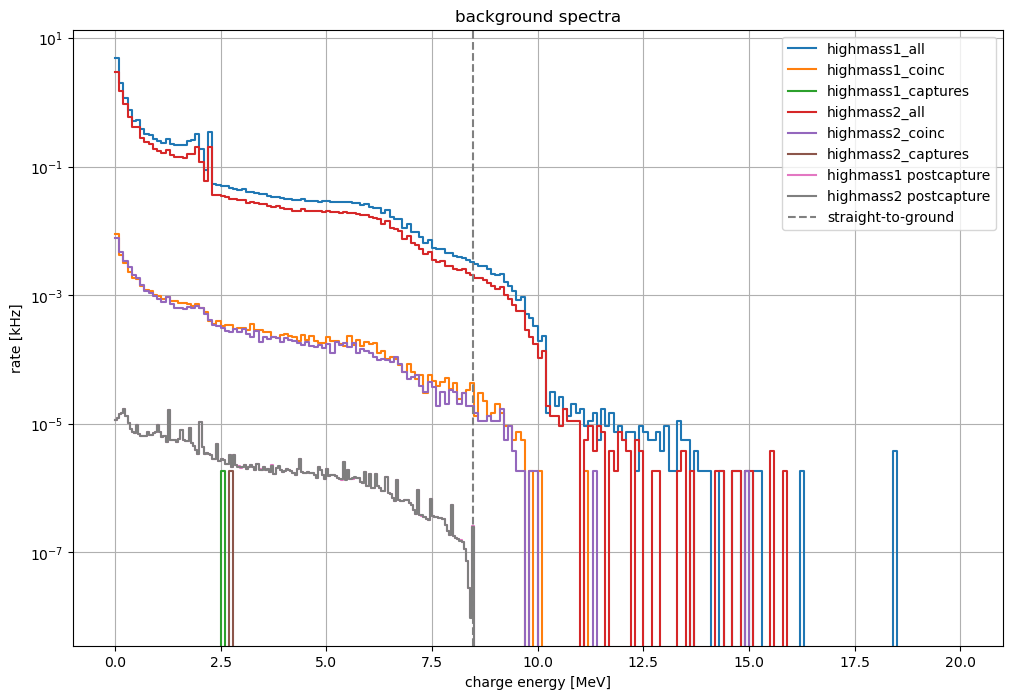

In [273]:
plt.figure(figsize = (12,8))
ax = plt.gca()

ax.set_title(f'background spectra')
Ebins = df['E'].values

for c in df.columns[1:]:
    y = df[c].values/1e3/leadrates.meas_exposures[meas]
    ax.step(Ebins, y, where = 'post', label = c)

for det in hm:
    ax.step(capcts.Ebins, capcts.cts[det]*capture_rate/capcts.Nprimaries/1e3, where = 'post', label = det + ' postcapture')

plt.axvline(E1, linestyle = 'dashed', color = 'gray', label = 'straight-to-ground')

ax.semilogy()
ax.grid()
ax.legend()
ax.set_xlabel('charge energy [MeV]')
ax.set_ylabel('rate [kHz]')


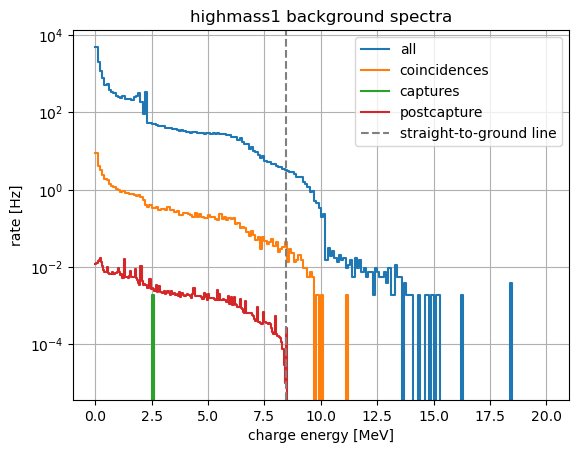

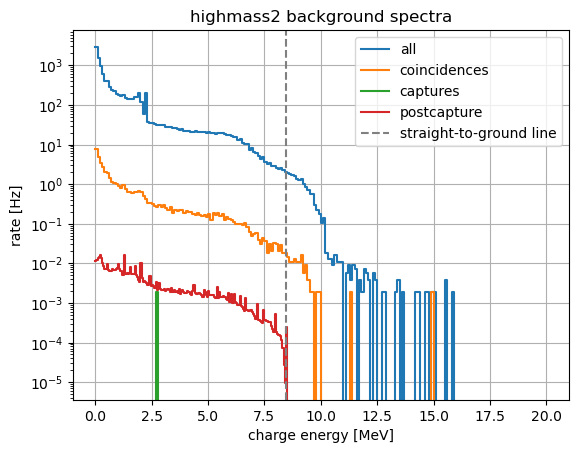

In [274]:
for det in hm:

    plt.figure()
    ax = plt.gca()

    ax.set_title(f'{det} background spectra')
    Ebins = df['E'].values

    for c in df.columns[1:]:
        if det in c:
            y = df[c].values/leadrates.meas_exposures[meas]
            ax.step(Ebins, y, where = 'post', label = c.split('_')[1] + ('idences' if 'coinc' in c else ''))


    ax.step(capcts.Ebins, capcts.cts[det]*capture_rate/capcts.Nprimaries, where = 'post', label = 'postcapture')

    plt.axvline(E1, linestyle = 'dashed', color = 'gray', label = 'straight-to-ground line')

    ax.semilogy()
    ax.grid()
    ax.legend()
    ax.set_xlabel('charge energy [MeV]')
    ax.set_ylabel('rate [Hz]')

(-0.9999994750000002, 20.999999975, 3.587691057006694e-06, 13470.526388710481)

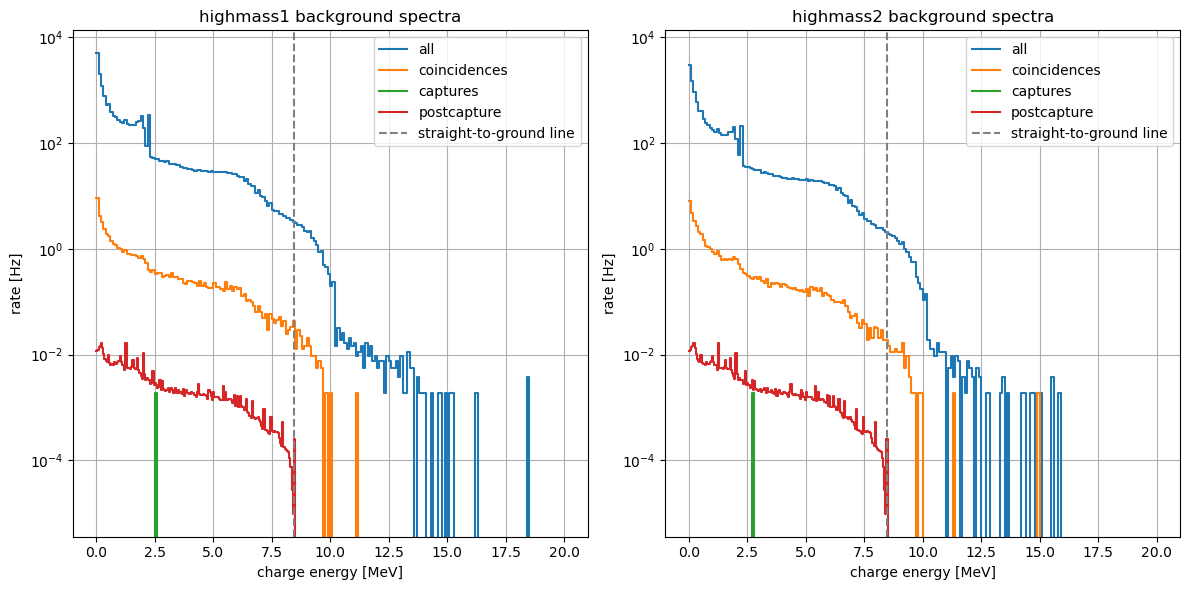

In [275]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

Ebins = df['E'].values

for det, ax in zip(hm, axs):

    ax.set_title(f'{det} background spectra')
    
    for c in df.columns[1:]:
        if det in c:
            y = df[c].values/leadrates.meas_exposures[meas]
            ax.step(Ebins, y, where = 'post', label = c.split('_')[1] + ('idences' if 'coinc' in c else ''))

    ax.step(capcts.Ebins, capcts.cts[det]*capture_rate/capcts.Nprimaries, where = 'post', label = 'postcapture')

    ax.axvline(E1, linestyle = 'dashed', color = 'gray', label = 'straight-to-ground line')


    ax.semilogy()
    ax.grid()
    ax.legend()
    ax.set_xlabel('charge energy [MeV]')
    ax.set_ylabel('rate [Hz]')



fig.tight_layout()
axs[1].axis(axs[0].axis())

In [276]:
window = 0.01 # size of window (MeV)
Emin = E1 - window
Emax = E1 + window
bins = 80
capmatch2 = 'simdata_20250302_113418_t*root'
cap_primaries_dict[capmatch2] = cap_primaries_dict[cap_match]

capcts2 = Counts(capmatch2, Emin = Emin, Emax = Emax, Nbins = bins, save = True)
df_dict2 = get_charge_histograms(leadrates, Emin = Emin, Emax = Emax, Nbins = bins)
df2 = df_dict2[meas]

loaded simdata_20250302_113418_t*root.txt


100%|██████████| 1600/1600 [34:09<00:00,  1.28s/it]


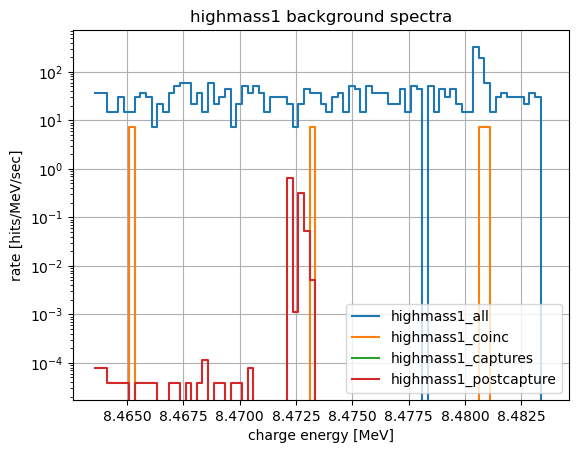

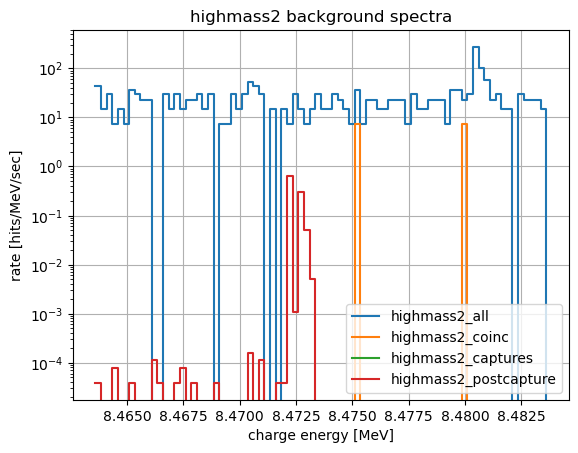

In [277]:
for det in hm:

    plt.figure()
    ax = plt.gca()

    ax.set_title(f'{det} background spectra')
    Ebins = df2['E'].values
    dE = (Ebins[1:] - Ebins[:-1]).mean()


    for c in df2.columns[1:]:
        if det in c:# and 'all' not in c:
            y = df2[c].values/leadrates.meas_exposures[meas]/dE
            dy = np.sqrt(df2[c].values)/leadrates.meas_exposures[meas]/dE
            ax.step(Ebins, y, where = 'post', label = c)
            #ax.errorbar(Ebins, y, yerr = 0*dy, label = c, linestyle = '-', marker = '_', capsize = 2)

    dEcap = np.diff(capcts2.Ebins).mean()
    capy = capcts2.cts[det]*capture_rate/capcts2.Nprimaries/dEcap
    dcapy = np.sqrt(capcts2.cts[det])*capture_rate/capcts2.Nprimaries/dEcap
    ax.step(capcts2.Ebins, capy, where = 'post', label = det + '_postcapture')
    #ax.errorbar(capcts2.Ebins, capy, yerr = dcapy, label = det + '_postcapture', linestyle = '', marker = '_', capsize = 2)

    #plt.axvline(E1, linestyle = 'dashed', color = 'gray', label = 'straight-to-ground')

    ax.semilogy()
    ax.grid()
    #ax.legend(loc = 'upper left')
    ax.legend()
    ax.set_xlabel('charge energy [MeV]')
    ax.set_ylabel('rate [hits/MeV/sec]')

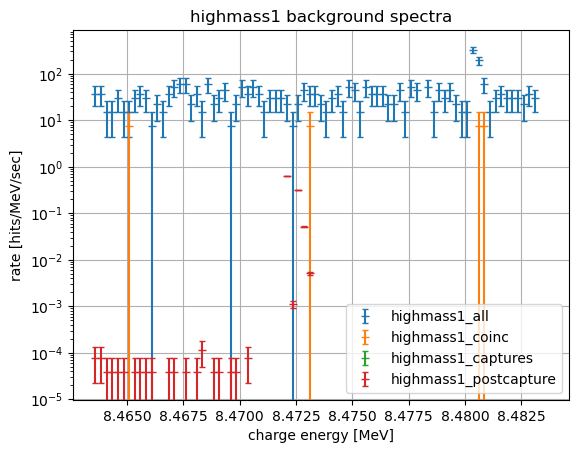

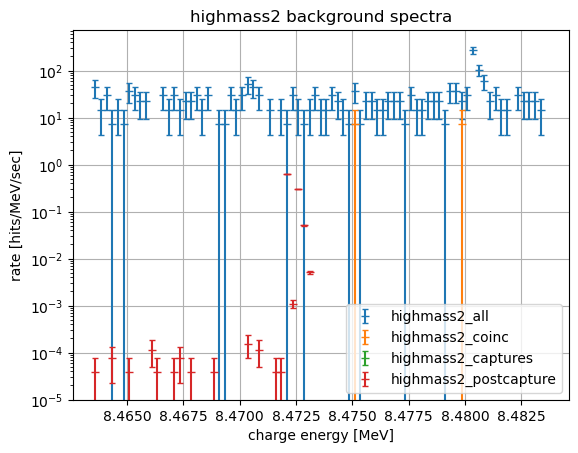

In [278]:
for det in hm:

    plt.figure()
    ax = plt.gca()

    ax.set_title(f'{det} background spectra')
    Ebins = df2['E'].values
    dE = (Ebins[1:] - Ebins[:-1]).mean()


    for c in df2.columns[1:]:
        if det in c:# and 'all' not in c:
            y = df2[c].values/leadrates.meas_exposures[meas]/dE
            dy = np.sqrt(df2[c].values)/leadrates.meas_exposures[meas]/dE
            #ax.step(Ebins, y, where = 'post', label = c)
            ax.errorbar(Ebins, y, yerr = dy, label = c, linestyle = '', marker = '_', capsize = 2)

    dEcap = np.diff(capcts2.Ebins).mean()
    capy = capcts2.cts[det]*capture_rate/capcts2.Nprimaries/dEcap
    dcapy = np.sqrt(capcts2.cts[det])*capture_rate/capcts2.Nprimaries/dEcap
    #ax.step(capcts2.Ebins, capy, where = 'post', label = det + '_postcapture')
    ax.errorbar(capcts2.Ebins, capy, yerr = dcapy, label = det + '_postcapture', linestyle = '', marker = '_', capsize = 2)

    #plt.axvline(E1, linestyle = 'dashed', color = 'gray', label = 'straight-to-ground')

    ax.semilogy()
    ax.grid()
    #ax.legend(loc = 'upper left')
    ax.legend()
    ax.set_xlabel('charge energy [MeV]')
    ax.set_ylabel('rate [hits/MeV/sec]')

In [308]:
df_dict3, lm_evts = get_charge_histograms(leadrates, Emin = Emin, Emax = Emax, Nbins = 1)
df3 = df_dict3[meas]

100%|██████████| 1600/1600 [34:23<00:00,  1.29s/it]


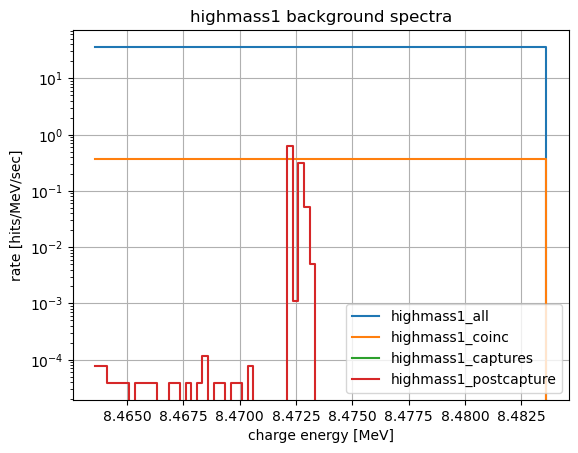

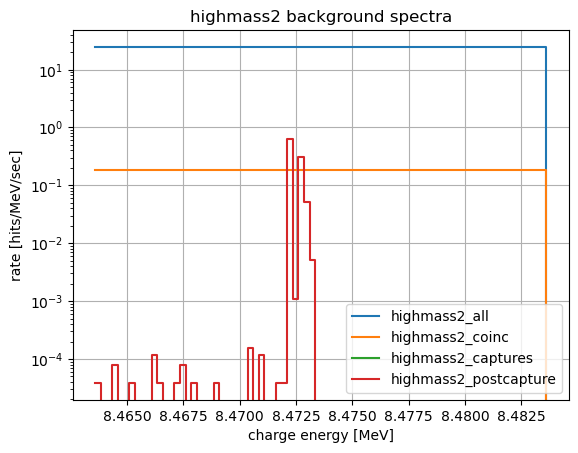

In [309]:
for det in hm:

    plt.figure()
    ax = plt.gca()

    ax.set_title(f'{det} background spectra')
    Ebins = df3['E'].values
    dE = (Ebins[1:] - Ebins[:-1]).mean()


    for c in df3.columns[1:]:
        if det in c:# and 'all' not in c:
            y = df3[c].values/leadrates.meas_exposures[meas]/dE
            dy = np.sqrt(df3[c].values)/leadrates.meas_exposures[meas]/dE
            ax.step(Ebins, y, where = 'post', label = c)
            #ax.errorbar(Ebins, y, yerr = 0*dy, label = c, linestyle = '-', marker = '_', capsize = 2)

    dEcap = np.diff(capcts2.Ebins).mean()
    capy = capcts2.cts[det]*capture_rate/capcts2.Nprimaries/dEcap
    dcapy = np.sqrt(capcts2.cts[det])*capture_rate/capcts2.Nprimaries/dEcap
    ax.step(capcts2.Ebins, capy, where = 'post', label = det + '_postcapture')
    #ax.errorbar(capcts2.Ebins, capy, yerr = dcapy, label = det + '_postcapture', linestyle = '', marker = '_', capsize = 2)

    #plt.axvline(E1, linestyle = 'dashed', color = 'gray', label = 'straight-to-ground')

    ax.semilogy()
    ax.grid()
    ax.legend(loc = 'lower right')
    #ax.legend()
    ax.set_xlabel('charge energy [MeV]')
    ax.set_ylabel('rate [hits/MeV/sec]')

In [ ]:
df3['highmass1_coinc'].values/leadrates.meas_exposures[meas]/dE # background rate in hits/MeV/sec

array([0.37, 0.  ])

In [314]:
dE

0.019999999999999574

In [310]:
df3.sum(axis = 0) # totals in each detector in range

E                      16.9472
highmass1_all         390.0000
highmass1_coinc         4.0000
highmass1_captures      0.0000
highmass2_all         266.0000
highmass2_coinc         2.0000
highmass2_captures      0.0000
dtype: float64

In [311]:
lm_evts

{'highmass1': [7.925321349276459e-08,
  0.19447464225119365,
  0.0098442,
  0.13310691123579685],
 'highmass2': [0.013662277143843798, 0.05755745364880907]}